In [44]:
#pip install ip2geotools
#pip install ipinfo
#conda install -c anaconda basemap


#tail -n+2 ~/.schlesi/crawler* | sed 's/\".*\"//g' |  cut -d',' -f11,14 

# how many nodes have i found?
#tail -n+2 ~/.schlesi/crawler* | grep 9925efd6 | sed 's/\".*\"//g' |  cut -d',' -f3,12,14 | sort -t ',' -k1,1 -k2,2nr -s -u | sort -t ',' -u -k1,1 | cut -d',' -f3 |sed -e "s/^enr://" | wc -l

In [31]:

import pandas as pd 
#import data from csv

dfs = []
for port in list(range(12000,12050)):
    file="~/.schlesi/crawler"+str(port)+".csv"
    df = pd.read_csv(file) 
    df.drop(columns=['index'])
    dfs.append(df)
df_all_with_dups = pd.concat(dfs).reset_index(drop=True).sort_values(by=['seq_no'], ascending=False) #ensure we keep highest seq no
df_all = df_all_with_dups.drop_duplicates(subset="node_id", keep = 'first').reset_index(drop=True)
df_all.set_index('node_id')
df = df_all[df_all['fork_digest']=='9925efd6']

len(df_all),len(df)

(151, 49)

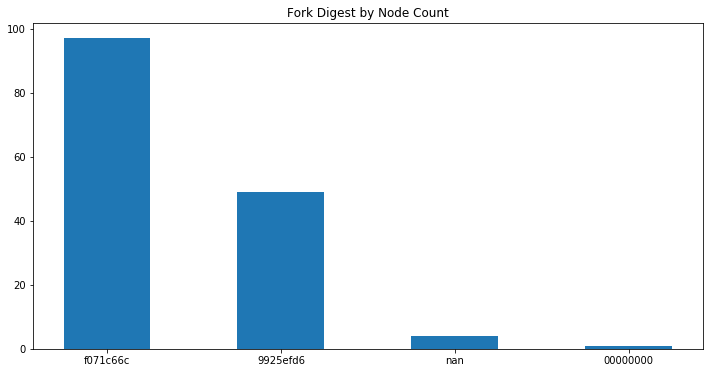

In [32]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt


fork_digests = df_all["fork_digest"].to_list()

counts = Counter(fork_digests)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title('Fork Digest by Node Count')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()


In [35]:
from collections import Counter 
node_ids = df["node_id"].to_list()
node_ids = [node_id.strip() for node_id in node_ids]
node_ids_freq = [Counter(node_id) for node_id in node_ids]
hex_chars = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
freqs = []
for node_id_freq in node_ids_freq:
    freqs.append([node_id_freq[hex_char] for hex_char in hex_chars])
    


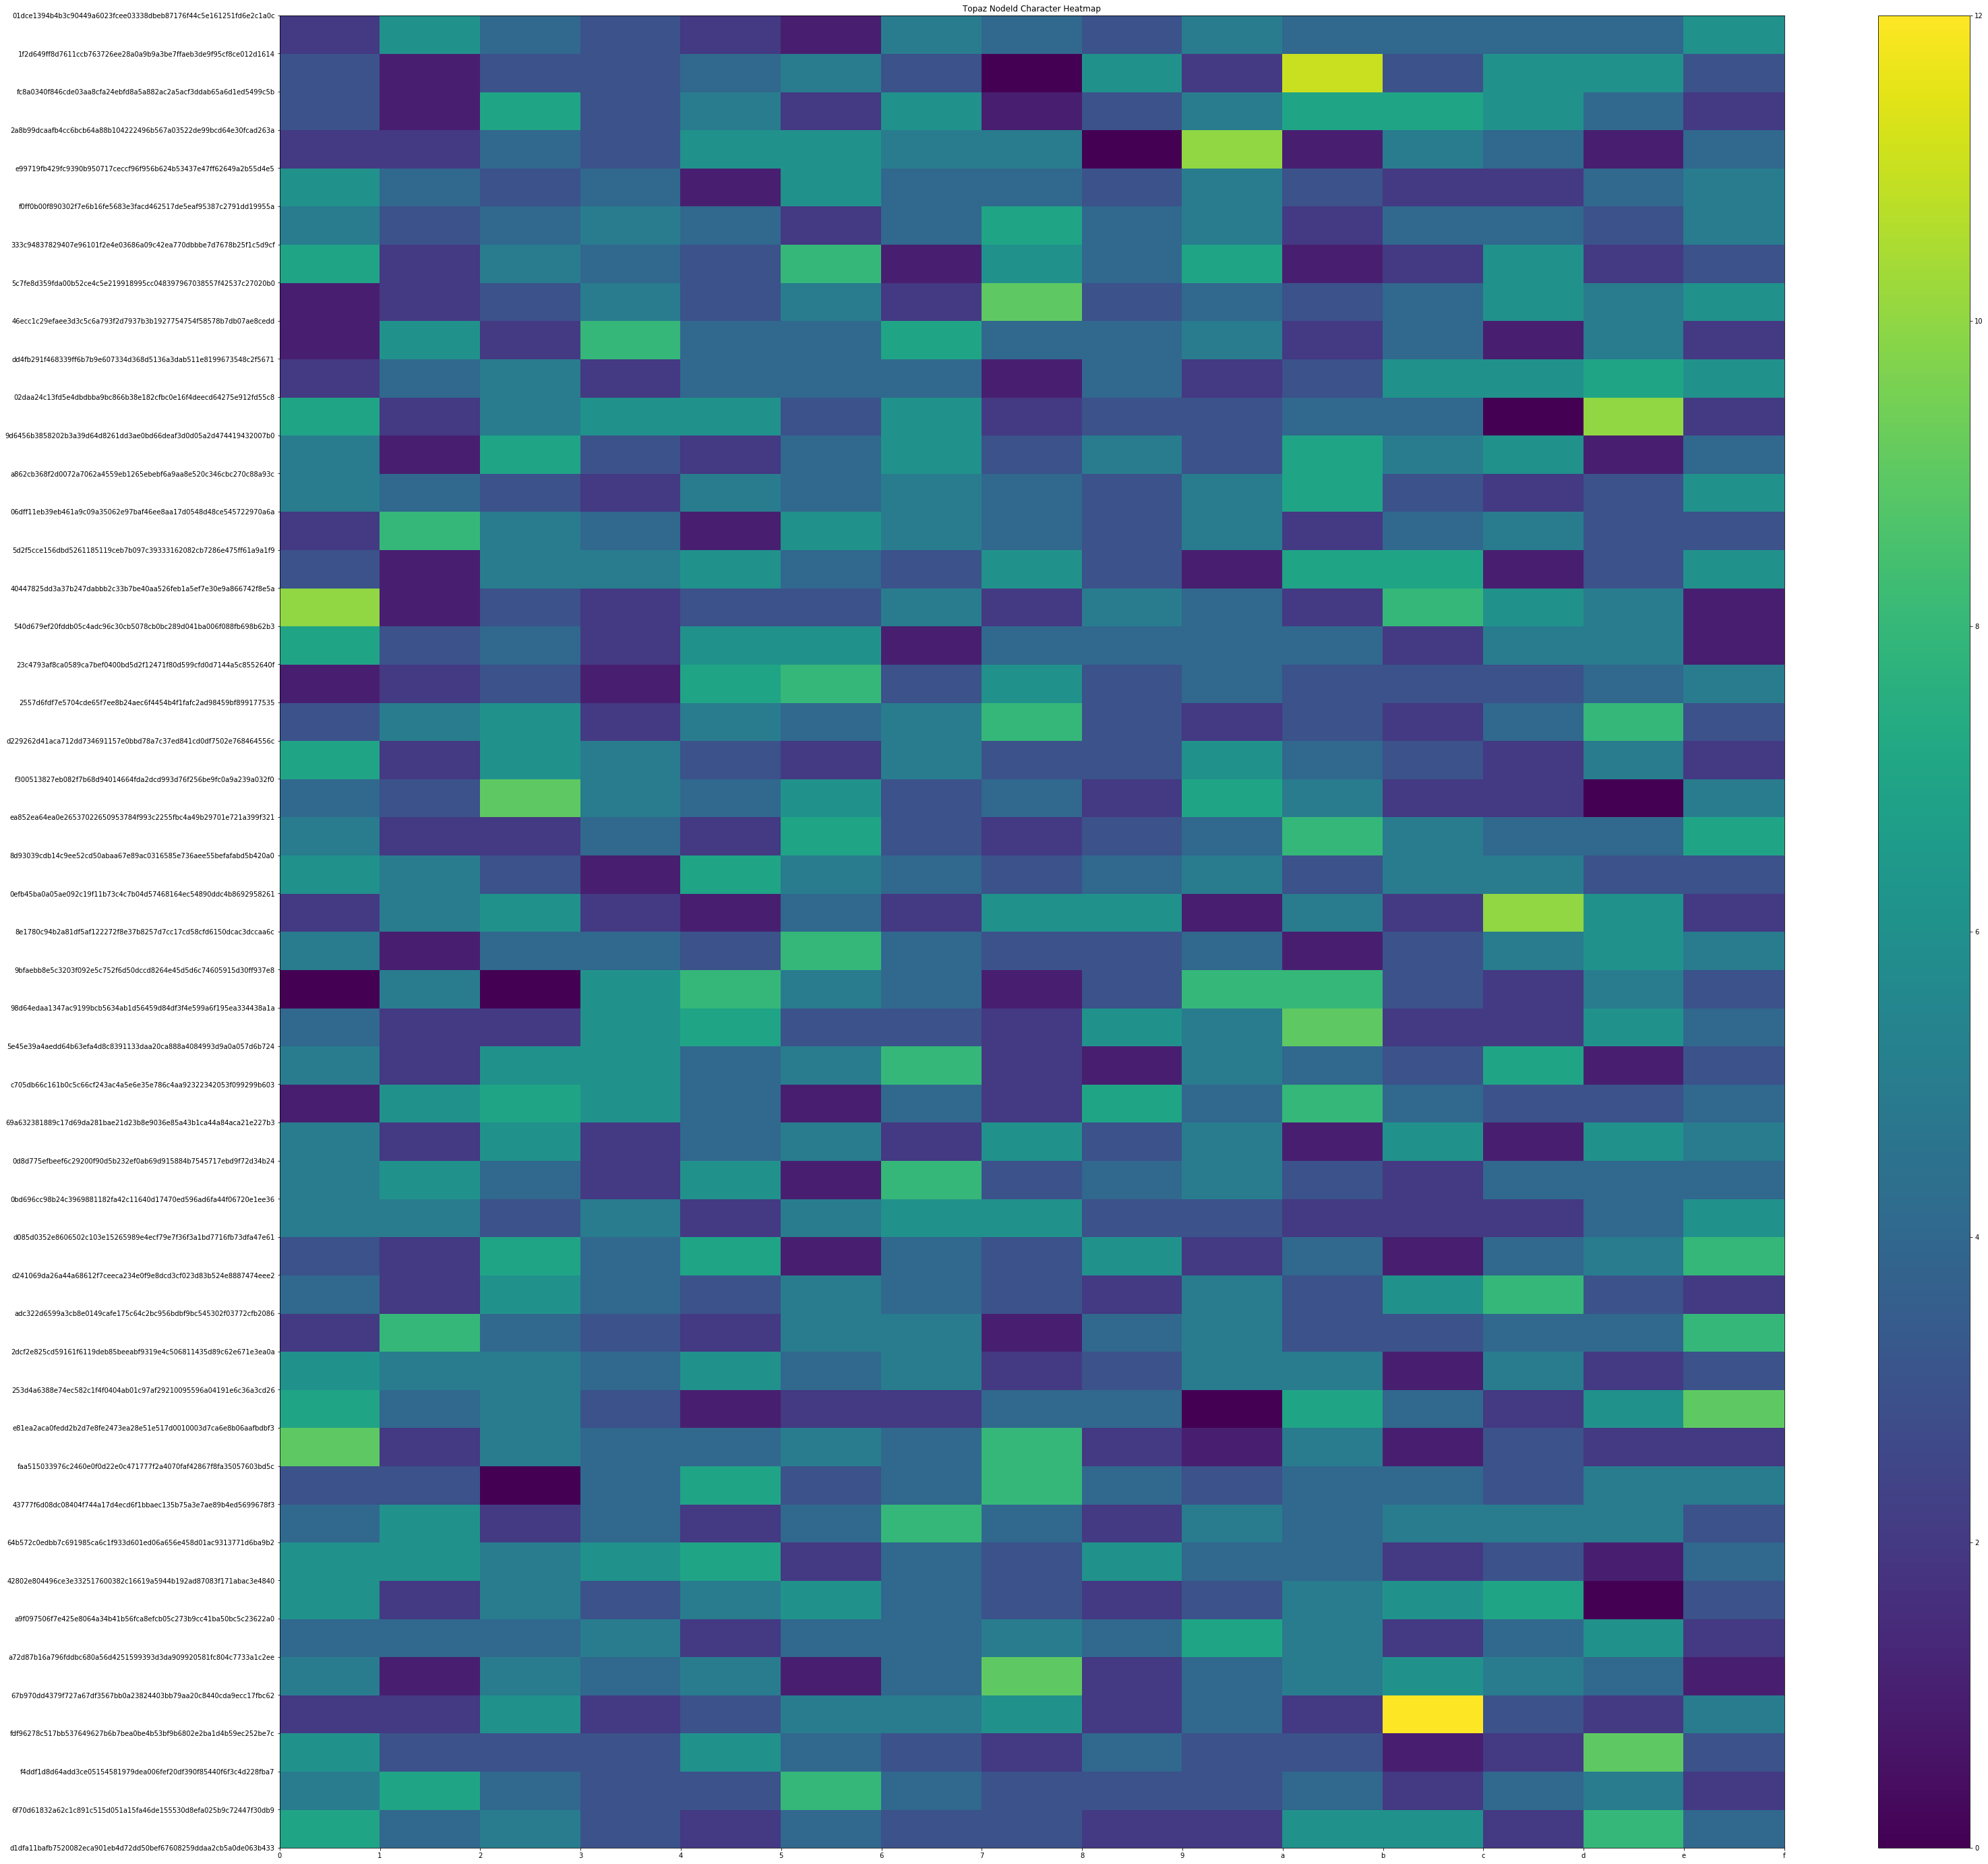

In [36]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(hex_chars, node_ids)
intensity = np.array(freqs)


plt.title('Topaz NodeId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()

In [37]:
import string
from collections import Counter 

peer_ids = df["peer_id"].to_list()

peer_ids_freq = [Counter(peer_id) for peer_id in peer_ids]
ascii_chars = [char for char in string.ascii_letters] + ['0','1','2','3','4','5','6','7','8','9']
freqs = []
for peer_id_freq in peer_ids_freq:
    freqs.append([peer_id_freq[char] for char in ascii_chars])


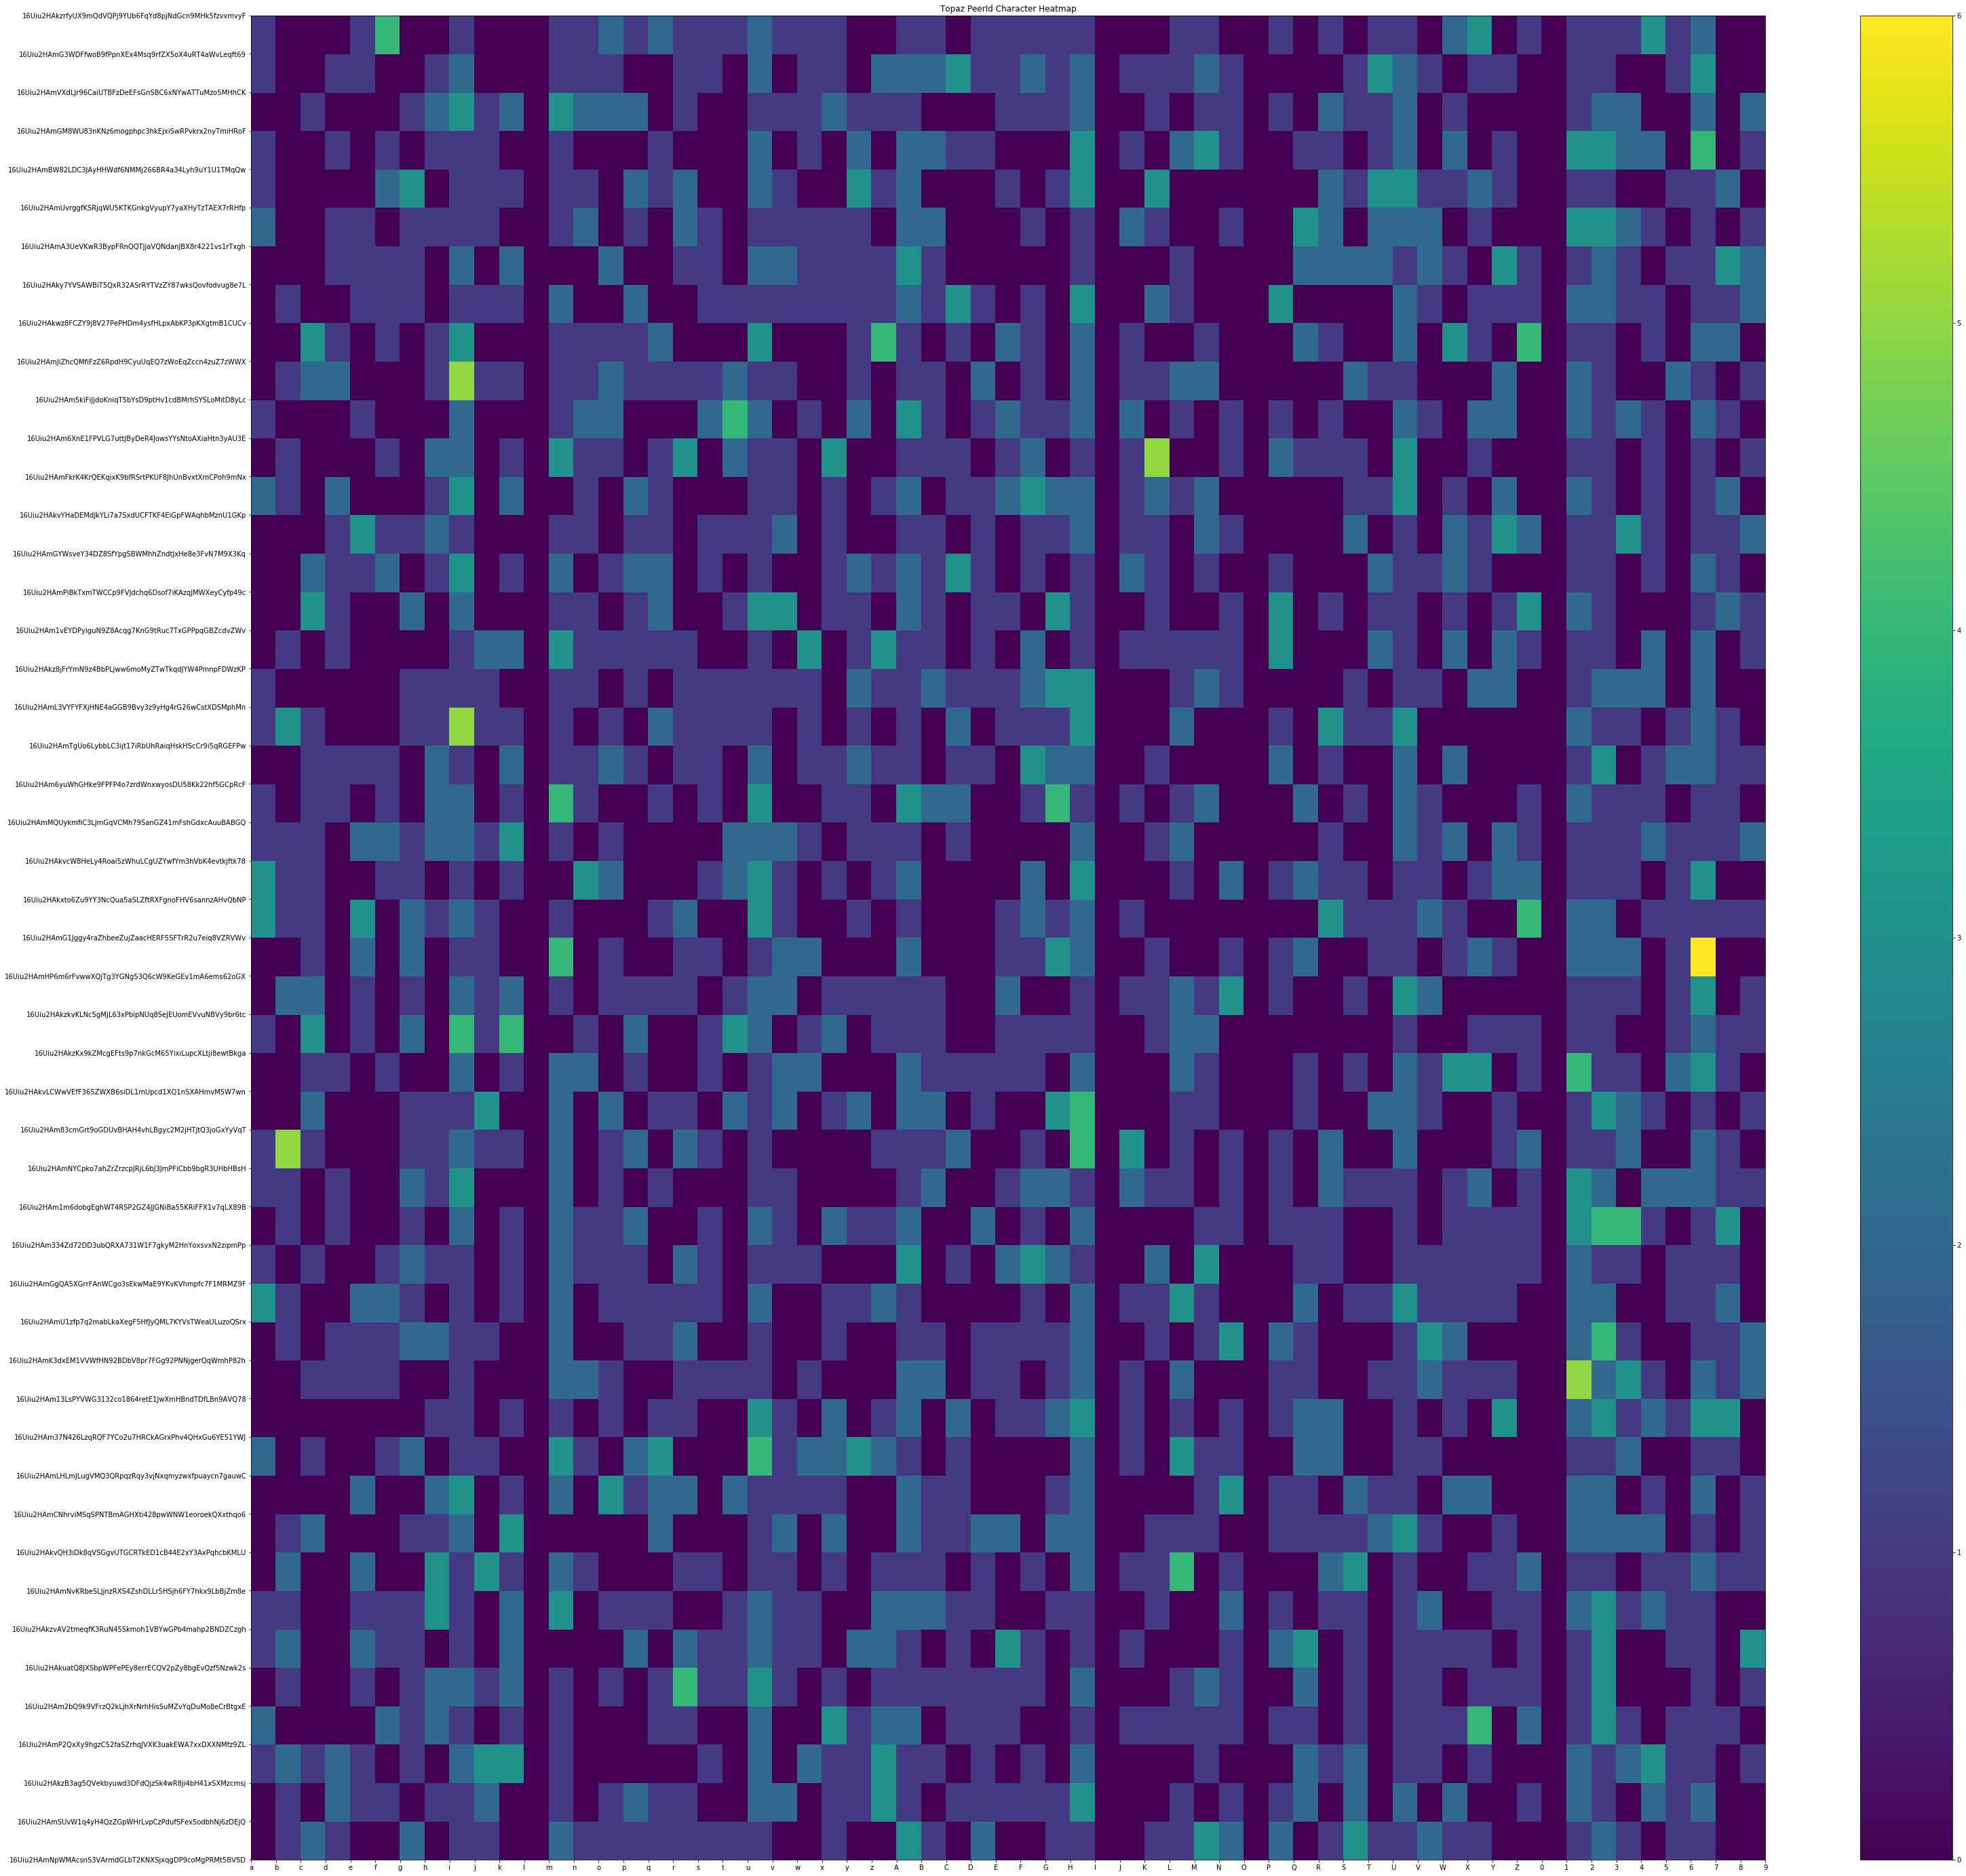

In [38]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.meshgrid(ascii_chars, peer_ids)
intensity = np.array(freqs)


plt.title('Topaz PeerId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar() 
plt.show() 

In [51]:
#from ip2geotools.databases.noncommercial import DbIpCity
#from ip2geotools.databases.noncommercial import Ipstack
#from ipaddress import ip_address

#ips = df["ip4"].to_list()
#bad_ips=["34.87.177.140","68.183.226.13","128.199.150.25","172.104.55.198"]
#ips = list(set(ips)-set(bad_ips))
#filtered_ips=[]
#for ip in ips:
#  a = ip_address(ip)
#  if not a.is_private:
#    filtered_ips.append(ip)
    
#ips_info_ip_city = [DbIpCity.get(ip, api_key='free') for ip in filtered_ips]
#ips_info = [Ipstack.get(ip, api_key='') for ip in filtered_ips]
#ips_info=[]
#for ip in filtered_ips:
#    print(ip)
#    ips_info.append(DbIpCity.get(ip, api_key='free'))



In [39]:
import ipinfo
import pickle

ips = df["ip4"].to_list()

# load any stored ip info
file = open('/Users/jonny/.topaz/ips_info.pkl', 'rb')
saved_ips_info = pickle.load(file)
file.close()

# determine what ips we need to lookup
need_info = []
for ip in ips:
    if ip not in saved_ips_info:
        need_info.append(ip)
        
print("Fetching missing info for ", len(need_info), " ip addresses.");
        
# get missing ip info
handler = ipinfo.getHandler('7bbf8b616179fb')
ips_info = [handler.getDetails(ip) for ip in need_info]

# save the ip info for next time

file = open('/Users/jonny/.topaz/ips_info.pkl', 'wb')

for ip_info in ips_info:
    saved_ips_info[ip_info.ip] = ip_info.all

pickle.dump(saved_ips_info,file)
file.close()

Fetching missing info for  0  ip addresses.


In [40]:
ips_info={}
for ip in ips:
    ips_info[ip]=saved_ips_info[ip]
    

In [41]:
#WHOIS
# whois -h whois.cymru.com " -v 62.210.170.177"
#  whois -h whois.arin.net 159.65.217.119
# whois -h whois.ripe.net 62.210.170.177
bad_ips = []
for ip,info in ips_info.items():
    if info['country_name'] == None:
        bad_ips.append(ip)
        
pd.set_option('max_colwidth', 100)
#pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 200)
#pd.reset_option('max_colwidth')
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.expand_frame_repr',False)

# collect node_ids of the records with bad ip addresses
bad_ip_node_ids = df[df['ip4'].isin(bad_ips)]['node_id'].to_list()
df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)]

,index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr
282,8,2020-05-08][18:22:44,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,192.168.0.105,13000.0,12000,NaN,NaN,NaN,9925efd6,394,[0],enr:-LS4QGU8xiLM_R5N0SV5SMazYn6fCvbBoELijLXm-P9wtAcscF6725bwemXb8oRA0s3e0ZAqYPrkawfYucizglVO8sKC...
2101,16,2020-05-08][18:22:47,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,192.168.0.105,13000.0,12000,NaN,NaN,NaN,9925efd6,394,[0],enr:-LS4QGU8xiLM_R5N0SV5SMazYn6fCvbBoELijLXm-P9wtAcscF6725bwemXb8oRA0s3e0ZAqYPrkawfYucizglVO8sKC...
817,9,2020-05-08][18:22:43,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,192.168.0.105,13000.0,12000,NaN,NaN,NaN,9925efd6,394,[0],enr:-LS4QGU8xiLM_R5N0SV5SMazYn6fCvbBoELijLXm-P9wtAcscF6725bwemXb8oRA0s3e0ZAqYPrkawfYucizglVO8sKC...
1549,39,2020-05-08][18:22:48,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,192.168.0.105,13000.0,12000,NaN,NaN,NaN,9925efd6,394,[0],enr:-LS4QGU8xiLM_R5N0SV5SMazYn6fCvbBoELijLXm-P9wtAcscF6725bwemXb8oRA0s3e0ZAqYPrkawfYucizglVO8sKC...
720,36,2020-05-08][18:22:41,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...
779,10,2020-05-08][18:22:49,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...
28,29,2020-05-08][18:22:44,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...
1844,32,2020-05-08][18:22:47,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...
126,48,2020-05-08][18:22:49,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...
522,10,2020-05-08][18:22:41,d1dfa11bafb7520082eca901eb4d72dd50bef67608259ddaa2cb5a0de063b433,16Uiu2HAmNpWMAcsnS3VArmdGLbT2KNXSjxqgDP9coMgPRMt5BVSD,87.180.197.55,13000.0,1024,NaN,NaN,12000.0,9925efd6,309,[0],enr:-Ly4QKCgsXfc7ZflGut-9PUylKMWoEhtnM4aoE2ANQrE_w2iX5a2hhBJakWdnbrCePXJr4uQ9QIccPBL9Yh1yWANEASC...


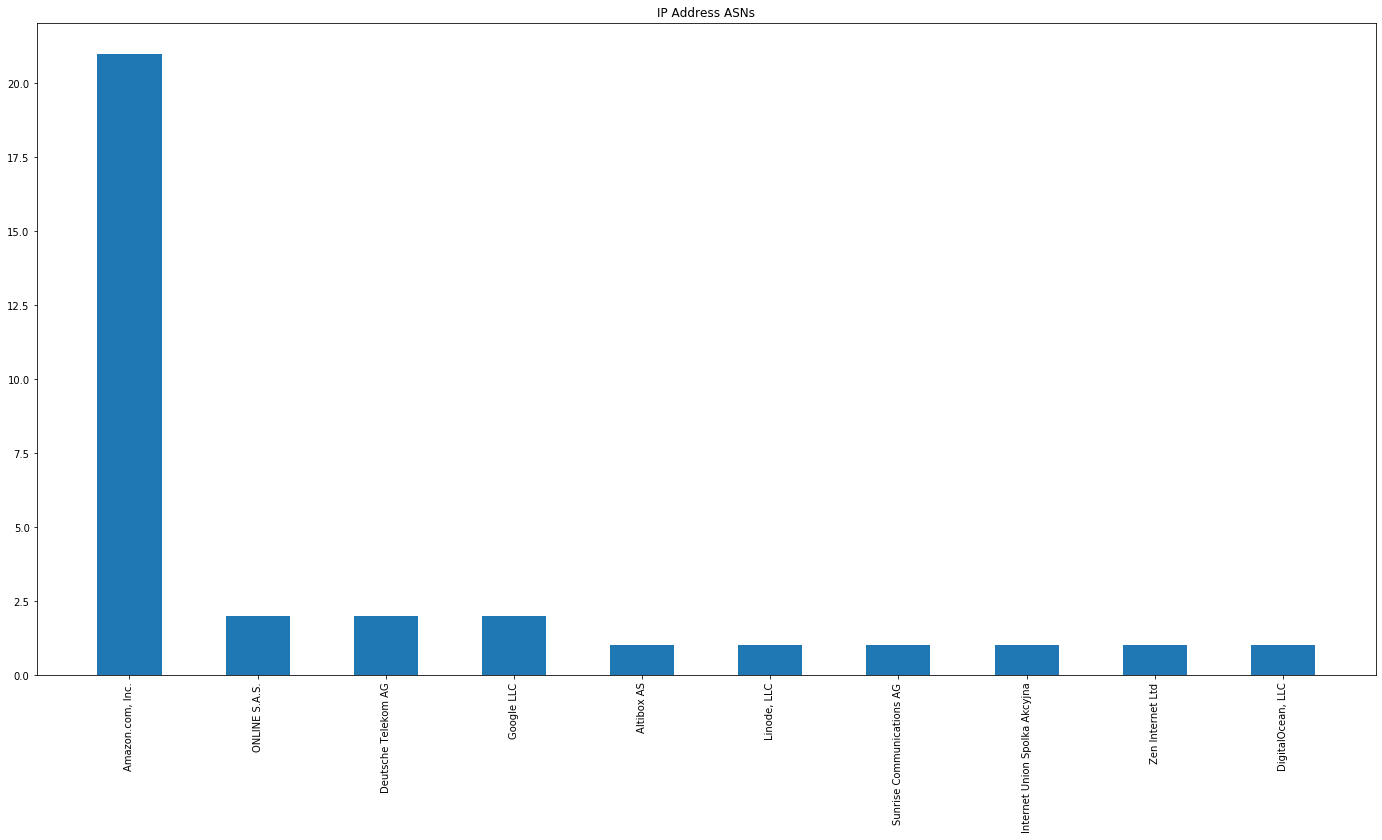

In [42]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

asn_orgs = [info['org'] if 'org' in info else 'None' for ip,info in ips_info.items()]
asn_orgs = [' '.join(org.split(' ')[1:]) for org in asn_orgs if org != 'None']

        
counts = Counter(asn_orgs)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,12))
plt.title('IP Address ASNs')
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels)
plt.show()



In [10]:
sum(values)


33

/Users/jonny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


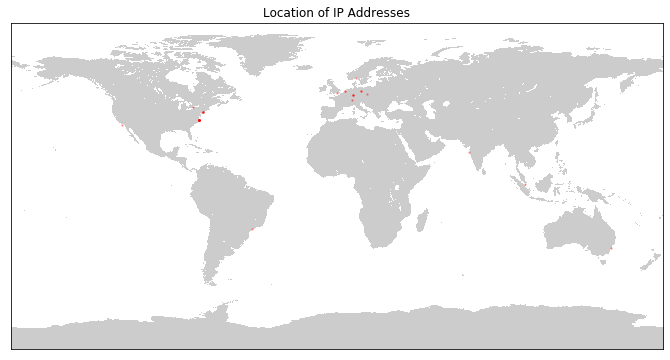

In [43]:
import os
os.environ['PROJ_LIB'] = '/Users/jonny/opt/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lats=[]
lons=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        lats.append(float(info['latitude']))
        lons.append(float(info['longitude']))


plt.figure(figsize=(12,6))
map = Basemap(projection='cyl', resolution='l')
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='#cc9955', lake_color='aqua')
#map.bluemarble()
map.drawlsmask()

x, y = map(lons, lats)
map.scatter(x, y, s=2, color='#ff0000', marker='o', alpha=0.3)
plt.title('Location of IP Addresses')
plt.show()

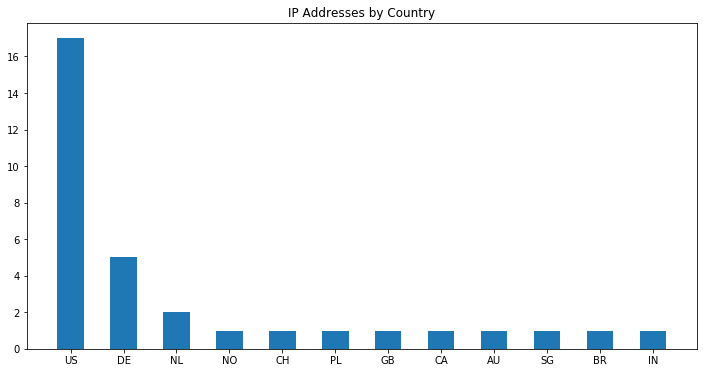

In [44]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

countries=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        countries.append(info['country'])


counts = Counter(countries)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title('IP Addresses by Country')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [46]:
subnets = df["subnet_ids"].to_list()
subnets = [subnet.replace('[','').replace(']','').replace(' ','') for subnet in subnets]
subnets = [subnet if len(subnet) > 0 else 'None' for subnet in subnets]
subnets = ','.join(subnets)
subnets = subnets.split(',')
labels = [str(label) for label in list(range(0,64))] + ['None']
values = [subnets.count(label) for label in labels]

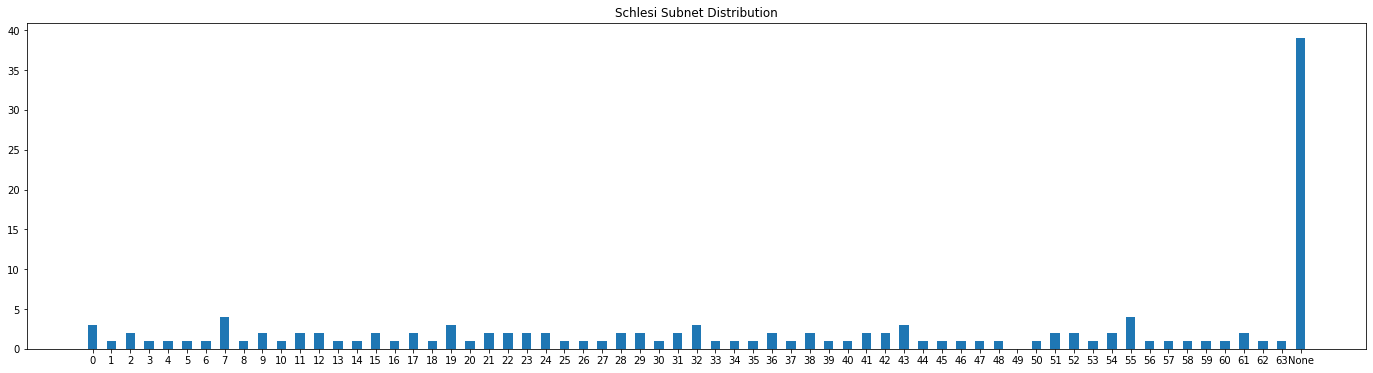

In [30]:
import numpy as np
import matplotlib.pyplot as plt

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,6))
plt.title('Schlesi Subnet Distribution')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [1]:
import pandas as pd 
# export each occurrence to it's own file
# awk  '/index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr/{close("FOO"i); x="FOO"++i;}{print > x;}' crawler12000.csv 
# number of files = 937
# grep -o -i 'index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr' crawler12000.csv |wc -l
th_dfs = []
for i in list(range(1,938)):
    file="~/Documents/projects/consensys/imp/scripts/output/FOO"+str(i)
    df = pd.read_csv(file) 
    df.drop(columns=['index'])
    df.set_index('node_id')
    th_dfs.append(df[df['fork_digest']=='9925efd6'])
 



In [2]:
th_df=th_dfs[0]

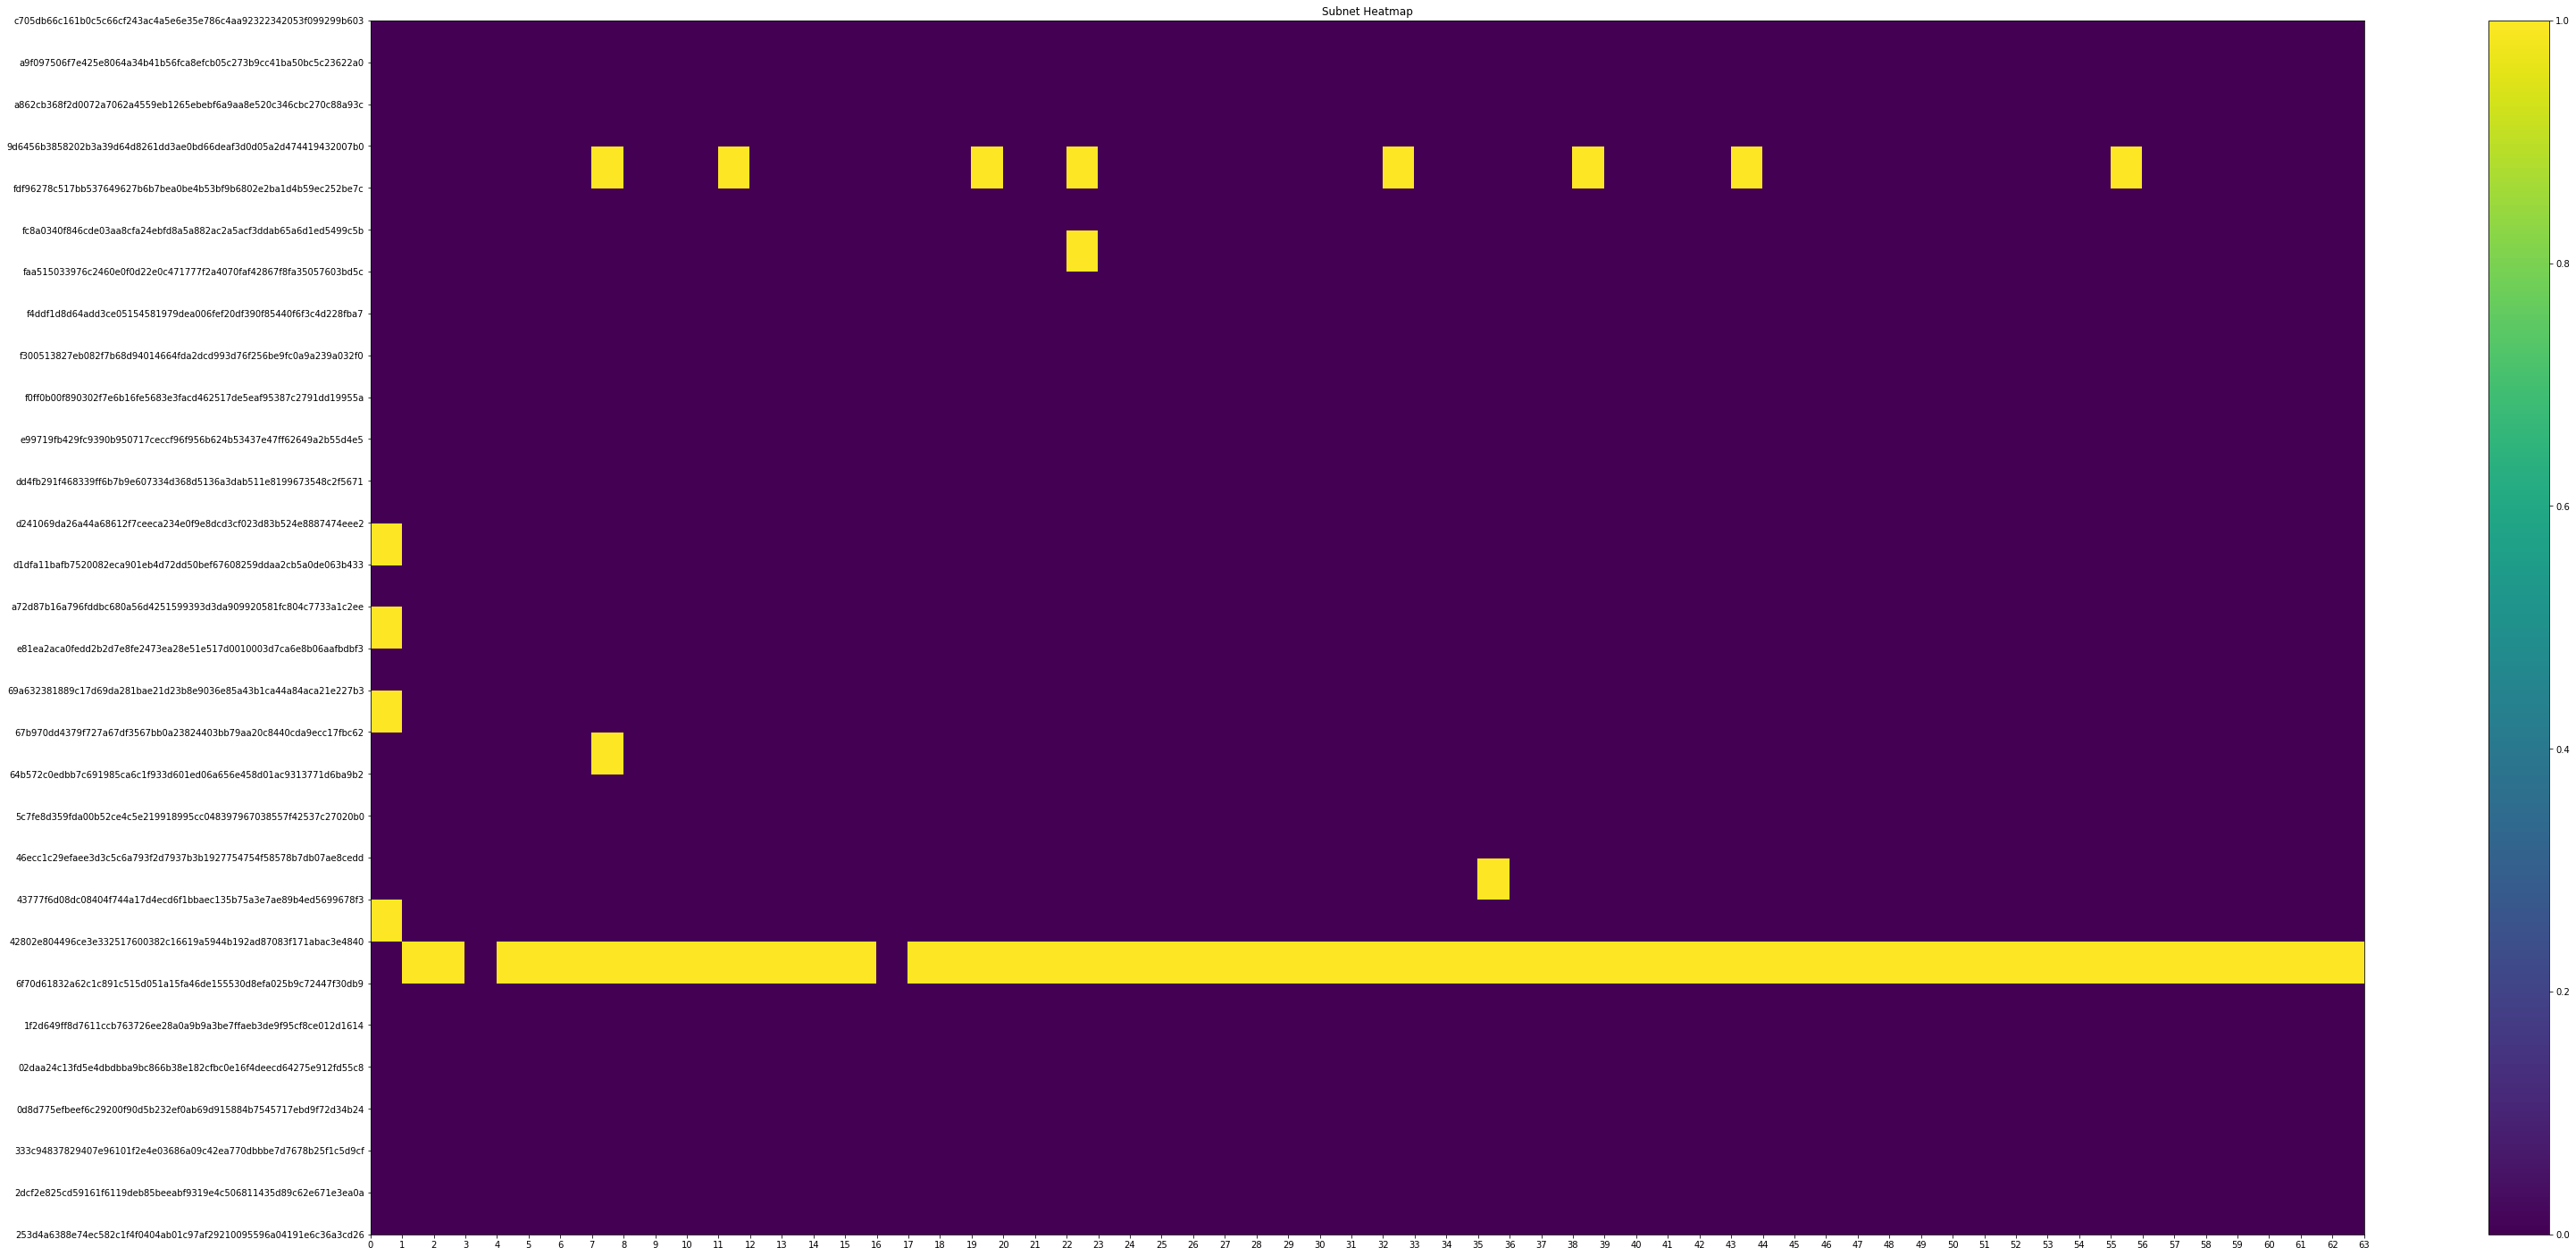

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import ast 
from collections import Counter 

node_ids = th_df["node_id"].to_list()

subnets = [label for label in list(range(0,64))] 
nodes_subnets = th_df["subnet_ids"].to_list()
nodes_subnets = [ast.literal_eval(node_subnets) for node_subnets in nodes_subnets]
subnet_freqs = [Counter(node_subnets) for node_subnets in nodes_subnets]

freqs = []
for subnet_freq in subnet_freqs:
    freqs.append([subnet_freq[subnet] for subnet in subnets])
    
x, y = np.meshgrid(subnets, node_ids)
intensity = np.array(freqs)

indexes = np.arange(len(subnets))
plt.title('Subnet Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.xticks(indexes, subnets)
plt.show()

In [2]:
#create list of unique node_ids

unique_node_ids = []

for th_df in th_dfs:
    unique_node_ids.extend(th_df["node_id"].to_list())

unique_node_ids = list(set(unique_node_ids))


possible_subnets = [label for label in list(range(0,64))] 

len(unique_node_ids)

30

<IPython.core.display.Javascript object>


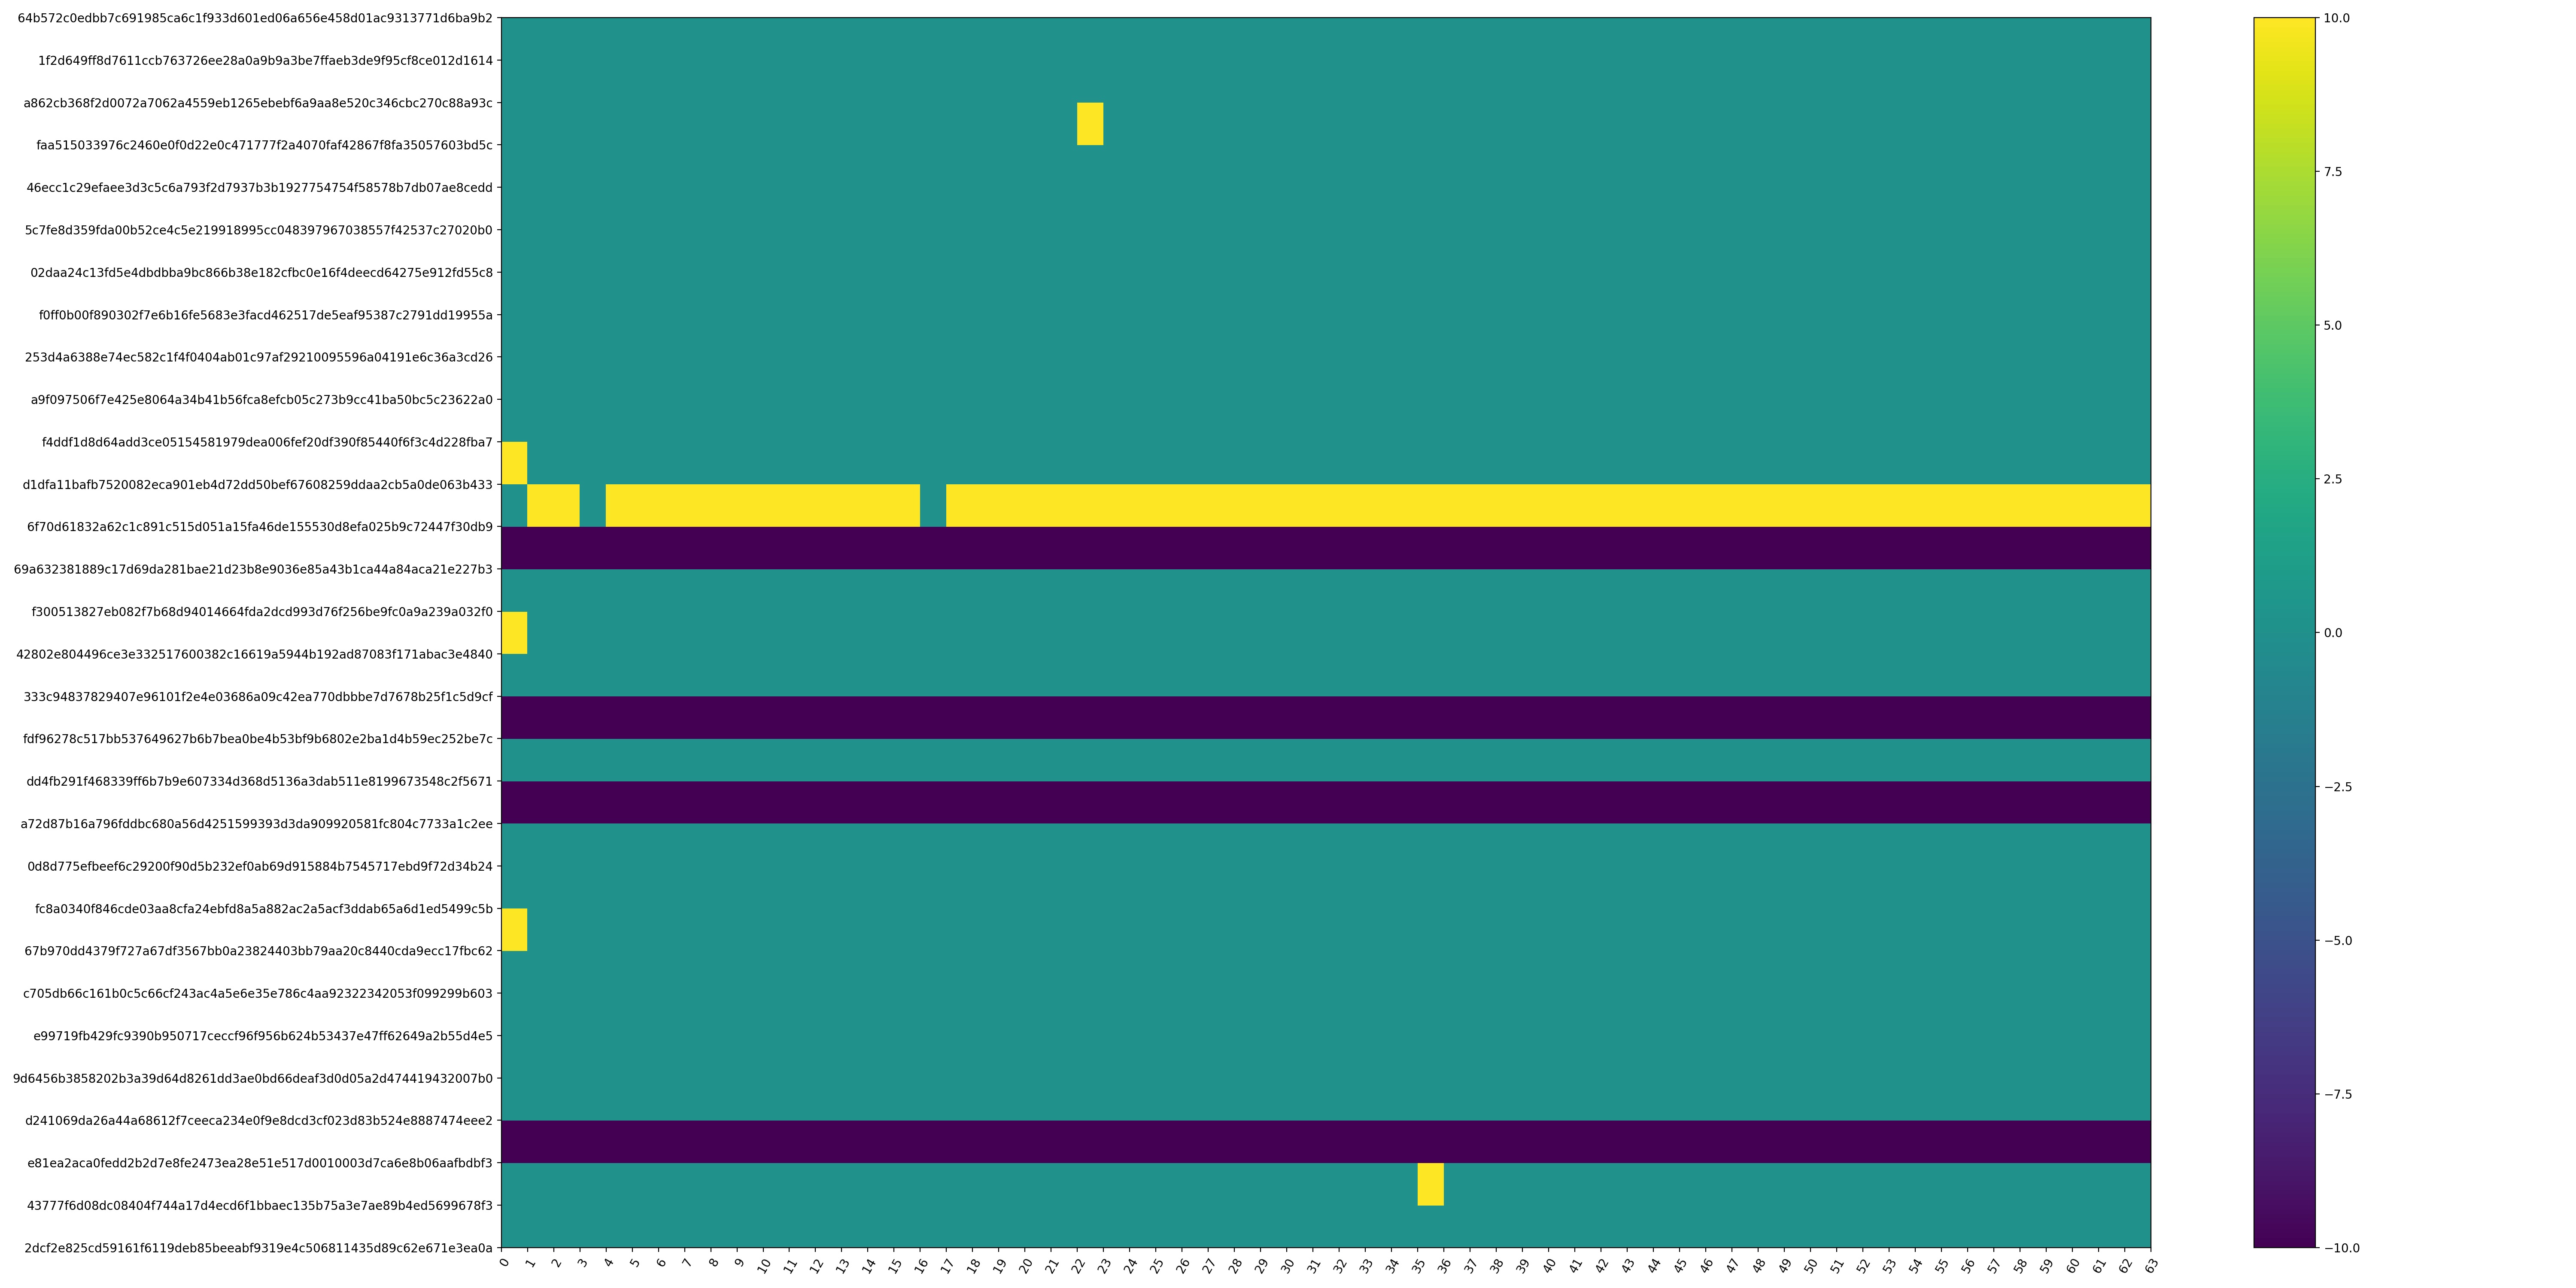

In [46]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np


import ast 
from collections import Counter 

# Some helper functions

# Initialize the board with starting positions
def update_board(th_df, boardsize):
    my_board = np.zeros((boardsize[0], boardsize[1]))
    for node_index, node_id in enumerate(unique_node_ids):
        if len(th_df[th_df['node_id'] == node_id]) > 0:
            subnets = th_df[th_df['node_id'] == node_id]['subnet_ids'].to_list()[0]
            subnets = ast.literal_eval(subnets)
            for subnet in subnets:
                my_board[node_index,subnet] = 10
        else:
            for subnet in possible_subnets:
                my_board[node_index,subnet] = -10

    return my_board


    
 
boardsize =  (len(unique_node_ids),len(possible_subnets)) 
    
# initialize with subnets from first frame
frame_num=0
my_board = update_board(th_dfs[frame_num], boardsize)

# Required line for plotting the animation
%matplotlib notebook


#plt.figure(figsize=(12,12))
# Initialize the plot of the board that will be used for animation
#fig = plt.gcf()
fig, ax = plt.subplots(figsize=(30,15))
# Show first image - which is the initial board
x, y = np.meshgrid(possible_subnets, unique_node_ids)
intensity = np.array(my_board)
plt.pcolormesh(x, y, intensity,vmin=-10., vmax=10.)
#im = ax.imshow(my_board)
ax.set_xticks( np.arange(len(possible_subnets)))
ax.set_xticklabels(possible_subnets)

plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.colorbar()
fig.tight_layout()

plt.show()
plt.savefig(fname='subnets', dpi=150)

def init():
    """initialize animation"""
    global im
    im = ax.imshow(np.zeros((boardsize[0], boardsize[1])))
    return im
    
# Helper function that updates the board and returns a new image of
# the updated board animate is the function that FuncAnimation calls
def animate(frame):
    global frame_num, x, y
    if frame_num > len(th_dfs):
        frame_num = 0
    else:
        frame_num += 1
    my_board = update_board(th_dfs[frame_num], boardsize)
    intensity = np.array(my_board)
    plt.pcolormesh(x, y, intensity,vmin=-10., vmax=10.)
    #im.set_data(update_board(th_dfs[frame_num], boardsize))
    #return im,

# This line creates the animation
anim = animation.FuncAnimation(fig, animate, frames=len(th_dfs), 
                               interval=33, blit=True)

#anim.save('subnet_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


,index,timestamp,node_id,peer_id,ip4,tcp4,udp4,ip6,tcp6,udp6,fork_digest,seq_no,subnet_ids,enr
